In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [74]:
data = pd.read_parquet('modeling_notebooks/data/rel_tweets_with_sentiment.gzip')
data.head()

,grid_id,tweet_id_x,created_at,text,author_id,place_id,lat,long,full_name,name,...,id,county,tweet_id_y,tag,relevance_pred,neg_sent_score,neu_sent_score,pos_sent_score,compound_sent_score,sent_class
0,40,820841383099437058,2017-01-16 03:53:30,Back of the camera preview from today at the r...,231610931,fbd6d2f5a4e4a15e,-121.697000,41.948800,"California, USA",California,...,40,SISKIYOU,8.208414e+17,1.0,1.0,0.094,0.906,0.000,-0.2411,negative
2,73,19057484971,2010-07-21 06:52:06,And now I hear coyotes... they better not hurt...,54453264,ca06c9bd1e591f53,NaN,NaN,"Butte Valley, CA",Butte Valley,...,73,SISKIYOU,1.905748e+10,1.0,1.0,0.000,0.579,0.421,0.7616,positive
3,101,364985527600033795,2013-08-07 05:45:05,Goal for tomorrow is to rope a coyote #gottah...,266238333,e057ac551ce5df02,-122.611145,41.742534,"Yreka, CA",Yreka,...,101,SISKIYOU,3.649855e+17,1.0,0.0,0.000,1.000,0.000,0.0000,neutral
4,101,1397357765811597312,2021-05-26 01:03:47,@numinousstock I could potentially run into a ...,2802522932,e057ac551ce5df02,NaN,NaN,"Yreka, CA",Yreka,...,101,SISKIYOU,1.397358e+18,1.0,1.0,0.000,1.000,0.000,0.0000,neutral
5,171,1037004682906857472,2018-09-04 15:49:17,@nazani14 @Dedpull_Diva We have coyotes here a...,781022262812114944,07d9f503d8884001,NaN,NaN,Lake Shastina Golf Course,Lake Shastina Golf Course,...,171,SISKIYOU,1.037005e+18,1.0,1.0,0.000,0.955,0.045,0.2732,positive


# Sentiment Analysis

## Check average and variance of compound sentiment score

In [75]:
sent_avg = data['compound_sent_score'].mean()
sent_var = data['compound_sent_score'].std()
print(f'Average Compound Sentiment Score: {sent_avg:.3f}')
print(f'Compound Sentiment Score Standard Deviation: {sent_var:.3f}')
print(f'Number of observations: {data.shape[0]}')

Average Compound Sentiment Score: 0.004
Compound Sentiment Score Standard Deviation: 0.449
Number of observations: 14202


The average compound score indicates that on average, there is a neutral sentiment towards human-coyote interactions. However, the standard deviation is relatively high indicating that the compound score can vary between positive and negative with one standard deviation up or down respectively.

## Let look at a histogram of the compound sentiment score and classification

In [76]:
class_counts = data.groupby('sent_class')['text'].count().sort_values(ascending=False)
class_counts

sent_class
positive    4777
neutral     4744
negative    4681
Name: text, dtype: int64

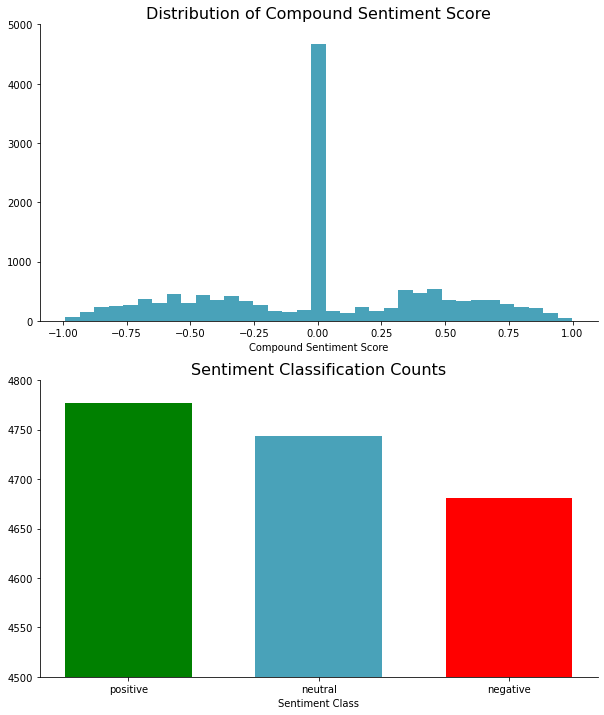

In [77]:
fig, ax = plt.subplots(figsize=(10, 12), nrows=2)
# Score histogram
ax[0].hist(data['compound_sent_score'], bins=35, color='#49a2b9')
ax[0].set_title('Distribution of Compound Sentiment Score', size=16)
ax[0].set_xlabel('Compound Sentiment Score')
ax[0].set_ylim(0, 5000)
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)

# Class bar
ax[1].bar(
    class_counts.index,
    class_counts,
    width=2/3,
    color=['green', '#49a2b9','red']
)
ax[1].set_title('Sentiment Classification Counts', size=16)
ax[1].set_xlabel('Sentiment Class')
ax[1].set_ylim(4500, 4800)
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)

plt.savefig('plots/sentiment_dis.png', transparent=False)
plt.show()

## Timeseries of compound score

In [78]:
# Look at min and max dates
data['created_at'].min(), data['created_at'].max()

(Timestamp('2010-03-23 18:48:21'), Timestamp('2022-03-01 04:49:47'))

In [79]:
# Get month-year
data['month_year'] = data['created_at'].dt.to_period('M').astype('string')

In [80]:
# Group by the month_year
sent_by_date = data.groupby('month_year', sort=True)['compound_sent_score'].mean()

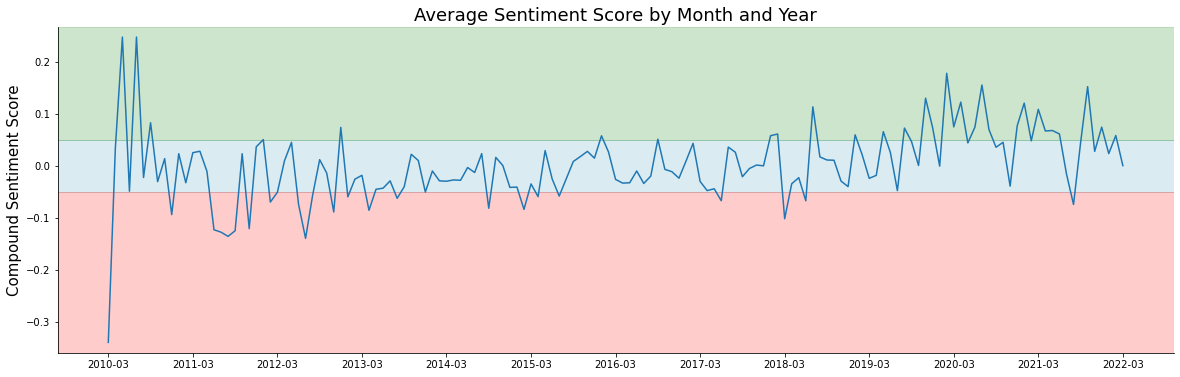

In [81]:
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(
    sent_by_date.index.values,
    sent_by_date.values
)
ax.set_xticks([sent_by_date.index.values[i] for i in range(0, len(sent_by_date), 12)])
ax.set_ylabel('Compound Sentiment Score', size=15)
ax.set_title('Average Sentiment Score by Month and Year', size=18)
ax.axhspan(-0.05, 0.05, alpha=.2, color='#49a2b9')
ax.axhspan(0.05, max(sent_by_date.values)+0.02, alpha=.2, color='green')
ax.axhspan(min(sent_by_date.values)-0.02, -0.05, alpha=.2, color='red')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylim(min(sent_by_date.values)-0.02, max(sent_by_date.values)+0.02)

plt.savefig('plots/sentiment_TS.png')
plt.show()

# Group data by county

In [82]:
county_group = data.groupby('county')['compound_sent_score'].mean().sort_values(ascending=False)
county_group

county
COLUSA             0.764200
MENDOCINO          0.489980
TEHAMA             0.191776
AMADOR             0.185000
CALAVERAS          0.174333
LAKE               0.159100
SHASTA             0.149295
MONO               0.142748
NAPA               0.141381
TUOLUMNE           0.134233
SISKIYOU           0.132283
SACRAMENTO         0.109684
KINGS              0.097454
SAN LUIS OBISPO    0.084406
HUMBOLDT           0.084283
MARIN              0.084110
MONTEREY           0.082979
CONTRA COSTA       0.082786
NEVADA             0.073971
EL DORADO          0.067890
SONOMA             0.067654
ALAMEDA            0.064111
SAN FRANCISCO      0.059460
SOLANO             0.055450
LASSEN             0.051600
VENTURA            0.049687
SANTA CLARA        0.048965
MARIPOSA           0.045954
PLACER             0.044237
SAN MATEO          0.044232
KERN               0.043105
MADERA             0.039647
IMPERIAL           0.035900
STANISLAUS         0.031465
YOLO               0.023922
BUTTE        

/var/folders/50/cgfcx8d97_52qyt5jj7jf52w0000gn/T/ipykernel_57419/3635848619.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(county_group.index.values, size=9)


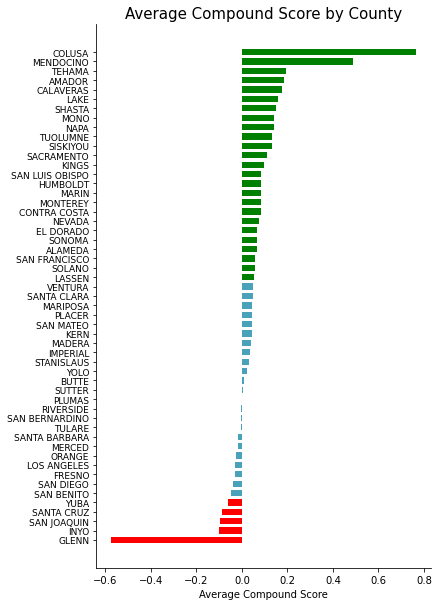

In [83]:
fig, ax = plt.subplots(figsize=(6, 10))
colors = []
for v in county_group.values:
    if v > 0.05:
        colors.append('green')
    elif v < -0.05:
        colors.append('red')
    else:
        colors.append('#49a2b9')


ax.barh(
    county_group.index.values,
    county_group.values,
    height=2/3,
    color=colors
)
ax.set_title('Average Compound Score by County', size=15)
ax.set_xlabel('Average Compound Score')
ax.set_yticklabels(county_group.index.values, size=9)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.gca().invert_yaxis()
plt.savefig('plots/sent_by_county.png')
plt.show()

Number of tweets by county

In [84]:
county_group = data.groupby('county')

In [85]:
tweet_count_by_count = county_group['compound_sent_score'].count().sort_values(ascending=False)

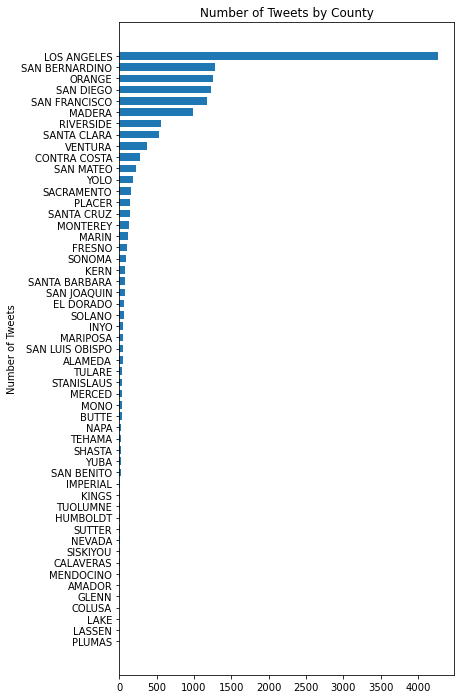

In [86]:
fig, ax = plt.subplots(figsize=(6, 12))
ax.barh(
    tweet_count_by_count.index.values,
    tweet_count_by_count.values,
    height=2/3
)
ax.set_title('Number of Tweets by County')
ax.set_ylabel('Number of Tweets')

plt.gca().invert_yaxis()
plt.show()

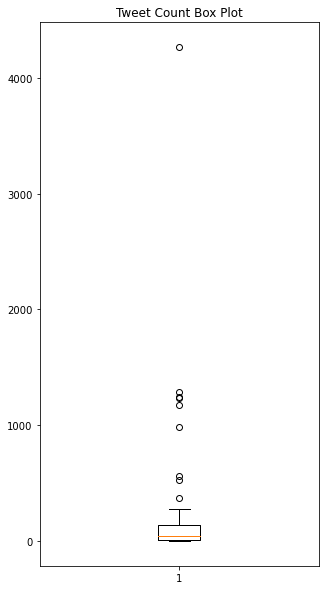

In [87]:
# Number of tweets box plot
fig, ax = plt.subplots(figsize=(5, 10))
ax.boxplot(tweet_count_by_count.values)
ax.set_title('Tweet Count Box Plot')
plt.show()

In [88]:
count_by_county = tweet_count_by_count.reset_index().rename(columns={'compound_sent_score': 'tweet_count'})

In [89]:
# Select counties with num_tweets > cutoff
cutoff = tweet_count_by_count.quantile(.3)
count_by_county_cf = count_by_county[count_by_county['tweet_count'] > cutoff]

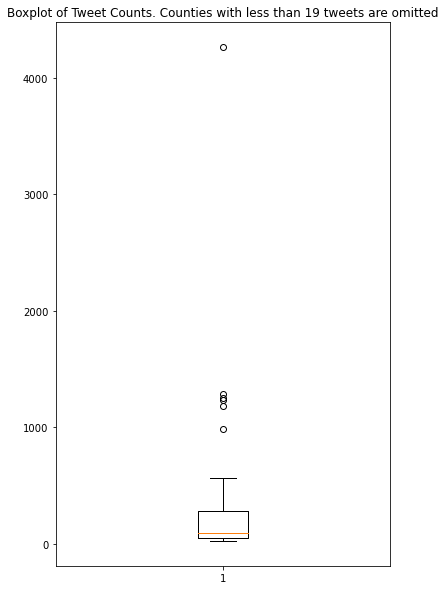

In [90]:
fig, ax = plt.subplots(figsize=(6, 10))
ax.boxplot(count_by_county_cf['tweet_count'])
ax.set_title(f'Boxplot of Tweet Counts. Counties with less than {int(cutoff)} tweets are omitted')
plt.show()

In [91]:
# Group data into county by month
data['month'] = data['created_at'].dt.month

In [92]:
data['month'].head()

0    1
2    7
3    8
4    5
5    9
Name: month, dtype: int64

In [93]:
county_month = data.groupby(['county', 'month'])

In [94]:
avg_ct_by_county_month = county_month['grid_id'].count() / 12

In [95]:
avg_ct_by_county_month[avg_ct_by_county_month>1]

county        month
CONTRA COSTA  1        2.166667
              2        2.916667
              3        1.333333
              4        2.166667
              5        1.333333
                         ...   
YOLO          5        1.583333
              7        1.500000
              8        1.333333
              10       1.250000
              11       1.333333
Name: grid_id, Length: 160, dtype: float64

In [96]:
avg_ct_by_county_month = avg_ct_by_county_month.unstack().fillna(0)
avg_ct_by_county_month

month,1,2,3,4,5,6,7,8,9,10,11,12
county,,,,,,,,,,,,
ALAMEDA,0.583333,0.500000,0.083333,0.166667,0.416667,0.250000,0.333333,0.500000,0.250000,0.250000,0.166667,0.416667
AMADOR,0.000000,0.000000,0.000000,0.000000,0.083333,0.000000,0.083333,0.000000,0.083333,0.000000,0.000000,0.000000
BUTTE,0.083333,0.166667,0.500000,0.166667,0.083333,0.416667,0.083333,0.250000,0.250000,0.083333,0.166667,0.333333
CALAVERAS,0.166667,0.000000,0.083333,0.083333,0.083333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.083333
COLUSA,0.083333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.083333,0.000000,0.000000,0.000000
CONTRA COSTA,2.166667,2.916667,1.333333,2.166667,1.333333,0.916667,2.083333,2.083333,2.166667,2.083333,1.666667,2.166667
EL DORADO,0.500000,0.500000,0.166667,0.250000,0.500000,0.333333,0.666667,0.750000,0.666667,0.583333,0.250000,0.666667
FRESNO,1.666667,0.583333,0.666667,0.583333,0.416667,0.750000,0.666667,0.583333,0.333333,0.916667,0.416667,0.916667
GLENN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.083333,0.083333,0.000000


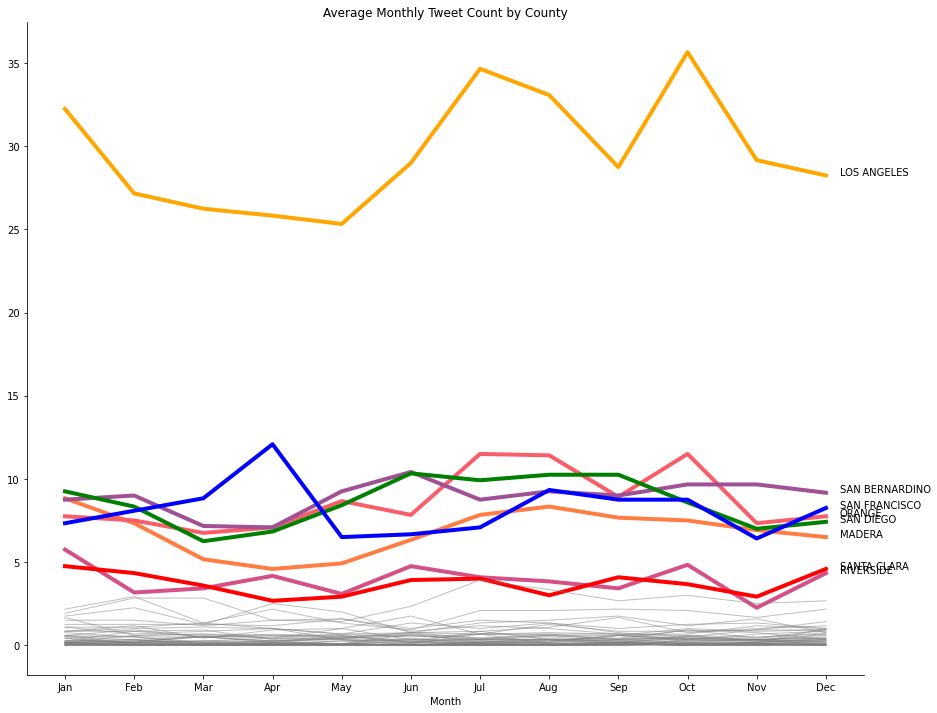

In [97]:
# Plot average tweet count by county by month
months_spelled = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
counties = avg_ct_by_county_month.index.values
months = avg_ct_by_county_month.columns.values
avg_tweet_counts = avg_ct_by_county_month.values
color = [
    '#ffa600',
    '#ff7c43',
    '#f95d6a',
    '#d45087',
    '#a05195',
    'green',
    'blue',
    'red'
]
color_idx = 0

fig, ax = plt.subplots(figsize=(15, 12))
for i in range(len(counties)):
    counts = avg_tweet_counts[i]
    county = counties[i]
    linewidth = 1
    line_color = 'gray'
    alpha=.5
    if counts.mean() > 3:
        ax.annotate(
            text=f'{county}',
            xy=(
                12+0.5,
                counts[-1]
            ),
            xytext=(
                12+0.2,
                counts[-1]
            ),
            annotation_clip=True,
            rotation=0

        )
        linewidth = 4
        line_color = color[color_idx]
        color_idx += 1
        alpha=1


    ax.plot(
        months,
        counts,
        label=county,
        linewidth=linewidth,
        color=line_color,
        alpha=alpha
    )
    # print(avg_tweet_counts.mean())


ax.set_title('Average Monthly Tweet Count by County')
ax.set_xlabel('Month')
ax.set_xticks(np.arange(1,13))
ax.set_xticklabels(months_spelled)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# plt.legend()
plt.show()

In [98]:
avg_monthly_count = (data.groupby('month')['grid_id'].count()/12).reset_index().rename(columns={'grid_id': 'count'})
avg_monthly_count

,month,count
0,1,106.833333
1,2,98.000000
2,3,86.666667
3,4,89.500000
4,5,87.833333
5,6,96.500000
6,7,108.583333
7,8,109.500000
8,9,100.833333
9,10,109.833333


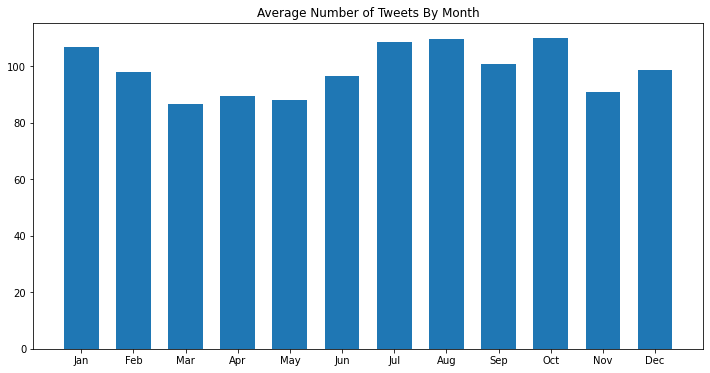

In [99]:
# Look at average number of tweets by month
fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(
    avg_monthly_count['month'],
    avg_monthly_count['count'],
    width=2/3
)
ax.set_title('Average Number of Tweets By Month')
ax.set_xticks(np.arange(1,13))
ax.set_xticklabels(months_spelled)
plt.show()

See number of tweets in LA by month by year

In [100]:
la = data[data['county']=='LOS ANGELES']

In [101]:
la.head()

,grid_id,tweet_id_x,created_at,text,author_id,place_id,lat,long,full_name,name,...,tweet_id_y,tag,relevance_pred,neg_sent_score,neu_sent_score,pos_sent_score,compound_sent_score,sent_class,month_year,month
5412,3262,101565693639667712,2011-08-11 08:08:43,the peacocks on the roof stomping is freaking ...,47112764,74834ae38c10ea95,-118.458426,34.680410,"North Antelope Valley, CA",North Antelope Valley,...,NaN,NaN,1.0,0.134,0.866,0.000,-0.4753,negative,2011-08,8
5413,3262,101580469312823296,2011-08-11 09:07:25,the crickets harmonizing with the coyotes. Dee...,47112764,74834ae38c10ea95,-118.452734,34.680151,"North Antelope Valley, CA",North Antelope Valley,...,NaN,NaN,1.0,0.000,0.769,0.231,0.6249,positive,2011-08,8
5414,3262,255159938807119873,2012-10-08 04:17:24,"On location, coyotes howling... Nice to be out...",22305245,74834ae38c10ea95,-118.455275,34.679698,"North Antelope Valley, CA",North Antelope Valley,...,NaN,NaN,1.0,0.000,0.823,0.177,0.4215,positive,2012-10,10
5415,3262,102288494784806912,2011-08-13 08:00:52,the coyotes are howling outside my window #ful...,47112764,74834ae38c10ea95,-118.458150,34.680690,"North Antelope Valley, CA",North Antelope Valley,...,NaN,NaN,1.0,0.000,0.787,0.213,0.4019,positive,2011-08,8
5416,3264,20743481828,2010-08-09 22:54:24,Hmm the roadkill on the Grapevine are huge. Sa...,7121092,None,NaN,NaN,None,None,...,NaN,NaN,1.0,0.151,0.729,0.120,-0.1531,negative,2010-08,8


In [102]:
la['year'] = la['created_at'].dt.year

/var/folders/50/cgfcx8d97_52qyt5jj7jf52w0000gn/T/ipykernel_57419/457592173.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  la['year'] = la['created_at'].dt.year


In [103]:
la.head()

,grid_id,tweet_id_x,created_at,text,author_id,place_id,lat,long,full_name,name,...,tag,relevance_pred,neg_sent_score,neu_sent_score,pos_sent_score,compound_sent_score,sent_class,month_year,month,year
5412,3262,101565693639667712,2011-08-11 08:08:43,the peacocks on the roof stomping is freaking ...,47112764,74834ae38c10ea95,-118.458426,34.680410,"North Antelope Valley, CA",North Antelope Valley,...,NaN,1.0,0.134,0.866,0.000,-0.4753,negative,2011-08,8,2011
5413,3262,101580469312823296,2011-08-11 09:07:25,the crickets harmonizing with the coyotes. Dee...,47112764,74834ae38c10ea95,-118.452734,34.680151,"North Antelope Valley, CA",North Antelope Valley,...,NaN,1.0,0.000,0.769,0.231,0.6249,positive,2011-08,8,2011
5414,3262,255159938807119873,2012-10-08 04:17:24,"On location, coyotes howling... Nice to be out...",22305245,74834ae38c10ea95,-118.455275,34.679698,"North Antelope Valley, CA",North Antelope Valley,...,NaN,1.0,0.000,0.823,0.177,0.4215,positive,2012-10,10,2012
5415,3262,102288494784806912,2011-08-13 08:00:52,the coyotes are howling outside my window #ful...,47112764,74834ae38c10ea95,-118.458150,34.680690,"North Antelope Valley, CA",North Antelope Valley,...,NaN,1.0,0.000,0.787,0.213,0.4019,positive,2011-08,8,2011
5416,3264,20743481828,2010-08-09 22:54:24,Hmm the roadkill on the Grapevine are huge. Sa...,7121092,None,NaN,NaN,None,None,...,NaN,1.0,0.151,0.729,0.120,-0.1531,negative,2010-08,8,2010


In [104]:
la_ct = la.groupby(['year', 'month'])['id'].count().unstack().dropna()
la_ct.loc[2012:2016].mean(axis=0)

month
1     33.2
2     28.0
3     28.2
4     28.2
5     27.8
6     35.8
7     40.0
8     38.2
9     34.8
10    41.8
11    34.0
12    30.2
dtype: float64

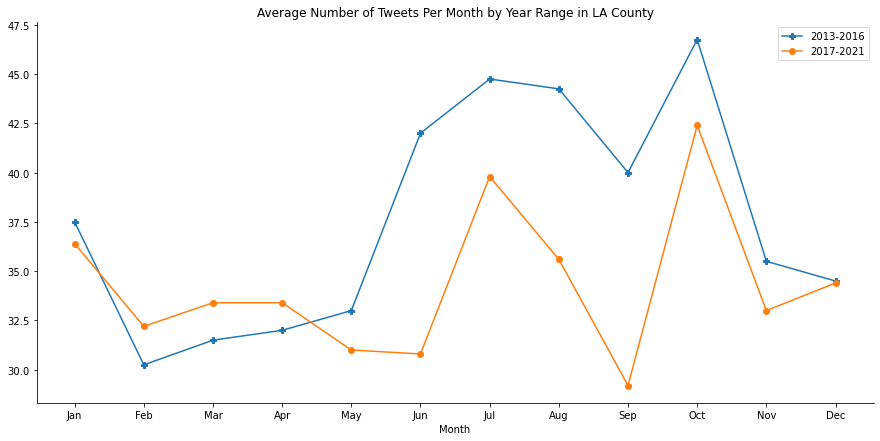

In [105]:
fig, ax = plt.subplots(figsize=(15, 7))
months = la_ct.columns.values
ax.plot(
    months,
    la_ct.loc[2013:2016].mean(axis=0),
    label='2013-2016',
    marker='P'
)

ax.plot(
    months,
    la_ct.loc[2017:2021].mean(axis=0),
    label='2017-2021',
    marker='o'
)

ax.set_title('Average Number of Tweets Per Month by Year Range in LA County')
ax.set_xlabel('Month')
ax.set_xticks(months)
ax.set_xticklabels(months_spelled)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.legend()
plt.show()

There seems like there is a pattern in the number of tweets by month. There are more tweets between June-October than there are from December-May

## Look at the sentiment for LA

In [110]:
la_data = data[data['county']=='LOS ANGELES']
la_data.head()

,grid_id,tweet_id_x,created_at,text,author_id,place_id,lat,long,full_name,name,...,tweet_id_y,tag,relevance_pred,neg_sent_score,neu_sent_score,pos_sent_score,compound_sent_score,sent_class,month_year,month
5412,3262,101565693639667712,2011-08-11 08:08:43,the peacocks on the roof stomping is freaking ...,47112764,74834ae38c10ea95,-118.458426,34.680410,"North Antelope Valley, CA",North Antelope Valley,...,NaN,NaN,1.0,0.134,0.866,0.000,-0.4753,negative,2011-08,8
5413,3262,101580469312823296,2011-08-11 09:07:25,the crickets harmonizing with the coyotes. Dee...,47112764,74834ae38c10ea95,-118.452734,34.680151,"North Antelope Valley, CA",North Antelope Valley,...,NaN,NaN,1.0,0.000,0.769,0.231,0.6249,positive,2011-08,8
5414,3262,255159938807119873,2012-10-08 04:17:24,"On location, coyotes howling... Nice to be out...",22305245,74834ae38c10ea95,-118.455275,34.679698,"North Antelope Valley, CA",North Antelope Valley,...,NaN,NaN,1.0,0.000,0.823,0.177,0.4215,positive,2012-10,10
5415,3262,102288494784806912,2011-08-13 08:00:52,the coyotes are howling outside my window #ful...,47112764,74834ae38c10ea95,-118.458150,34.680690,"North Antelope Valley, CA",North Antelope Valley,...,NaN,NaN,1.0,0.000,0.787,0.213,0.4019,positive,2011-08,8
5416,3264,20743481828,2010-08-09 22:54:24,Hmm the roadkill on the Grapevine are huge. Sa...,7121092,None,NaN,NaN,None,None,...,NaN,NaN,1.0,0.151,0.729,0.120,-0.1531,negative,2010-08,8


In [113]:
la_sent_by_month = la_data.groupby('month')['compound_sent_score'].mean().reset_index(drop=False)

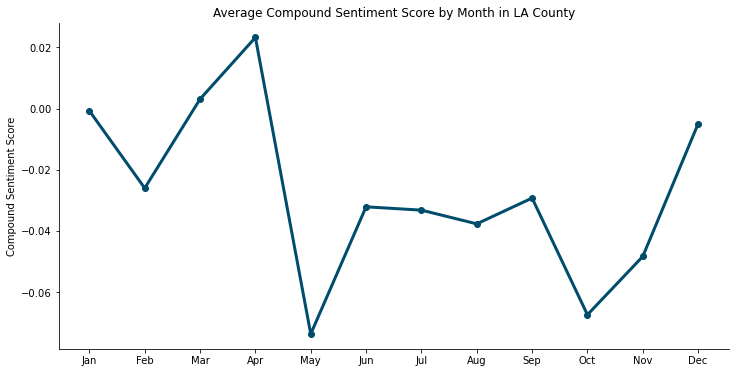

In [121]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(
    la_sent_by_month['month'],
    la_sent_by_month['compound_sent_score'],
    marker='o',
    color='#004c6d',
    linewidth=3
)

# ax.axhline(y=0, color='gray')

ax.set_title('Average Compound Sentiment Score by Month in LA County')
ax.set_xticks(np.arange(1,13))
ax.set_xticklabels(months_spelled)
ax.set_ylabel('Compound Sentiment Score')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()

Split by year ranges

In [134]:
la_sent_by_month_year = la.groupby(['year', 'month'])['compound_sent_score'].mean().unstack().dropna()
la_sent_by_month_year.loc[2012:2016].mean(axis=0)

month
1    -0.047204
2    -0.056974
3    -0.010534
4     0.021281
5    -0.080193
6    -0.075047
7    -0.079837
8    -0.060359
9    -0.044817
10   -0.033941
11   -0.052529
12    0.025815
dtype: float64

In [163]:
la_ct

month,1,2,3,4,5,6,7,8,9,10,11,12
year,,,,,,,,,,,,
2011,17.0,7.0,7.0,2.0,8.0,13.0,13.0,26.0,24.0,5.0,12.0,10.0
2012,16.0,19.0,15.0,13.0,7.0,11.0,21.0,14.0,14.0,22.0,28.0,13.0
2013,21.0,21.0,19.0,12.0,17.0,23.0,11.0,37.0,20.0,42.0,26.0,47.0
2014,50.0,33.0,35.0,40.0,34.0,40.0,46.0,48.0,49.0,32.0,30.0,27.0
2015,32.0,27.0,31.0,37.0,39.0,51.0,56.0,42.0,45.0,50.0,51.0,29.0
2016,47.0,40.0,41.0,39.0,42.0,54.0,66.0,50.0,46.0,63.0,35.0,35.0
2017,30.0,39.0,36.0,32.0,33.0,34.0,58.0,35.0,38.0,39.0,37.0,37.0
2018,40.0,32.0,47.0,38.0,29.0,44.0,33.0,35.0,29.0,50.0,36.0,49.0
2019,51.0,43.0,20.0,29.0,24.0,34.0,50.0,43.0,36.0,39.0,31.0,33.0


In [136]:
from sklearn.preprocessing import MinMaxScaler

In [219]:
sc = MinMaxScaler((1,20))

In [220]:
scaled_la_counts = sc.fit_transform(la_ct)
scaled_la_counts

array([[ 1.54285714,  1.        ,  1.        ,  1.        ,  1.54285714,
         1.88372093,  1.69090909,  7.33333333,  6.42857143,  1.        ,
         1.        ,  1.        ],
       [ 1.        ,  7.33333333,  4.8       ,  5.64444444,  1.        ,
         1.        ,  4.45454545,  1.        ,  1.        ,  6.56896552,
         8.79487179,  2.46153846],
       [ 3.71428571,  8.38888889,  6.7       ,  5.22222222,  6.42857143,
         6.30232558,  1.        , 13.13888889,  4.25714286, 13.12068966,
         7.82051282, 19.02564103],
       [19.45714286, 14.72222222, 14.3       , 17.04444444, 15.65714286,
        13.81395349, 13.09090909, 18.94444444, 20.        ,  9.84482759,
         9.76923077,  9.28205128],
       [ 9.68571429, 11.55555556, 12.4       , 15.77777778, 18.37142857,
        18.6744186 , 16.54545455, 15.77777778, 17.82857143, 15.74137931,
        20.        , 10.25641026],
       [17.82857143, 18.41666667, 17.15      , 16.62222222, 20.        ,
        20.        , 2

In [221]:
sc_la_counts_13_16 = scaled_la_counts[1:6].mean(axis=0)
sc_la_counts_16_22 = scaled_la_counts[6:-1].mean(axis=0)
sc_la_counts_16_22

array([14.43571429, 15.77777778, 14.41875   , 15.56666667, 14.16428571,
       11.93604651, 12.05454545, 13.13888889,  9.55      , 14.59482759,
       12.20512821, 13.54487179])

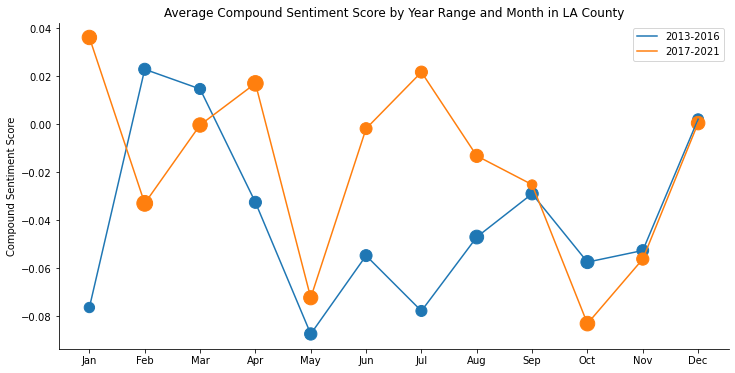

In [224]:
fig, ax = plt.subplots(figsize=(12, 6))
# 2012-2016
ax.plot(
    months,
    la_sent_by_month_year.loc[2013: 2016].mean(axis=0),
    label='2013-2016'
)

ax.plot(
    months,
    la_sent_by_month_year.loc[2017: 2021].mean(axis=0),
    label='2017-2021'
)

ax.scatter(
    months,
    la_sent_by_month_year.loc[2013: 2016].mean(axis=0),
    s=sc_la_counts_13_16**2
)

ax.scatter(
    months,
    la_sent_by_month_year.loc[2017: 2021].mean(axis=0),
    s=sc_la_counts_16_22**2
)

ax.set_title('Average Compound Sentiment Score by Year Range and Month in LA County')
ax.set_xticks(np.arange(1,13))
ax.set_xticklabels(months_spelled)
ax.set_ylabel('Compound Sentiment Score')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.legend()
plt.show()